# VIX Cross Asset Volatility with Dispersion

1. Looking at VIX vs. MOVE

# Packages

In [16]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

FIGSIZE = (16, 6)

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

if os.path.exists(data_path) == False: os.makedirs(data_path)
if os.path.exists(out_path) == False: os.makedirs(out_path)

# Collect Data

In [3]:
df_yf = pd.read_parquet(
    path = os.path.join(data_path, "yf.parquet"),
    engine = "pyarrow")

# VIX vs. MOVE

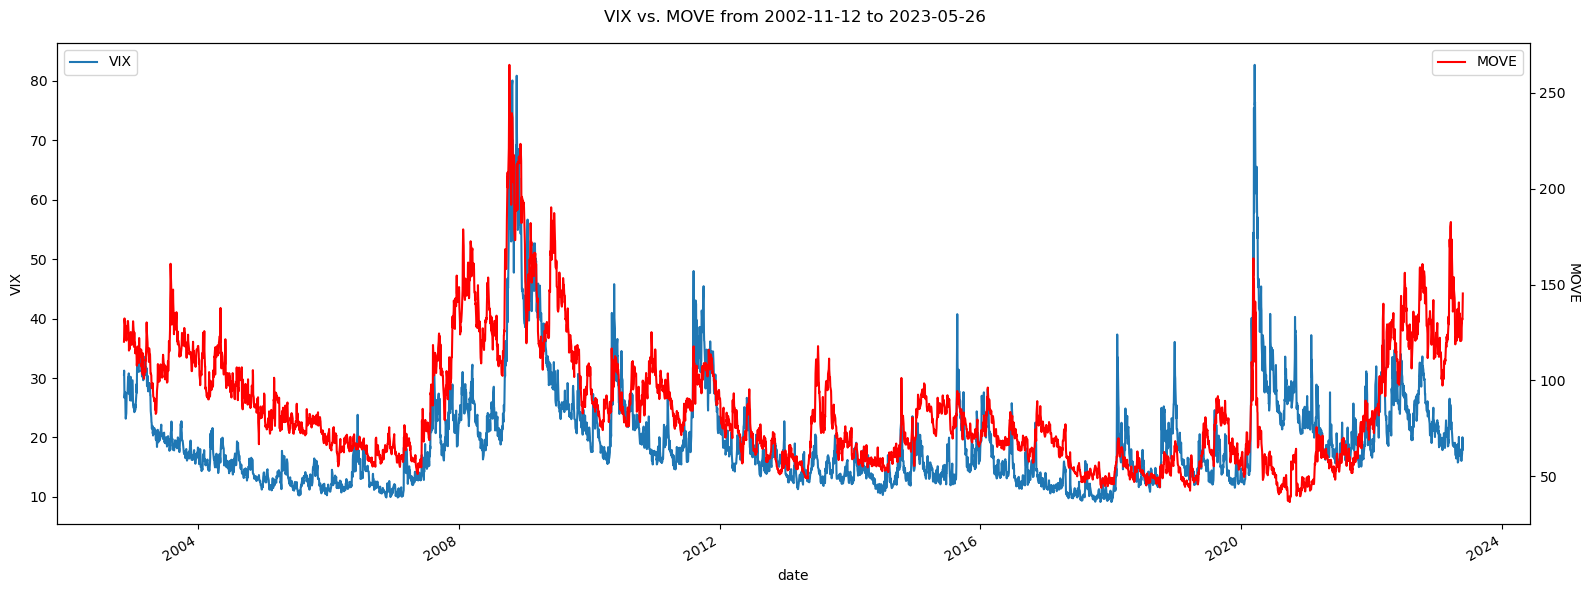

In [4]:
df_yf_prep = (df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    dropna())

fig, axes = plt.subplots(figsize = FIGSIZE)
axes_copy = axes.twinx()

(df_yf_prep[[
    "VIX"]].
    plot(ax = axes, ylabel = "VIX", label = "VIX"))

(df_yf_prep[
    ["MOVE"]].
    plot(ax = axes_copy, color = "red"))

axes_copy.set_ylabel("MOVE", rotation = 270, labelpad = 10)
axes_copy.legend(loc = "upper right")
axes.legend(loc = "upper left")

fig.suptitle("VIX vs. MOVE from {} to {}".format(
    df_yf_prep.index.min().date(),
    df_yf_prep.index.max().date()))

plt.tight_layout()
plt.savefig(os.path.join(out_path, "vix_move.jpeg"), dpi = 150)
plt.show()

# Get Rolling Z-Score Spread

In [5]:
def _get_z_score(df):
    return(df.assign(
        df_rtn = lambda x: x.value.pct_change(),
        df_mean = lambda x: x.df_rtn.rolling(window = 120).mean(),
        df_std = lambda x: x.df_rtn.rolling(window = 120).std(),
        z_score = lambda x: (x.df_mean - x.df_rtn) / x.df_std).
        drop(columns = ["df_mean", "df_std", "df_rtn"]))

df_z_score = (df_yf.groupby(
    "variable").
    apply(_get_z_score).
    drop(columns = ["value"]).
    pivot(index = "date", columns = "variable", values = "z_score"))

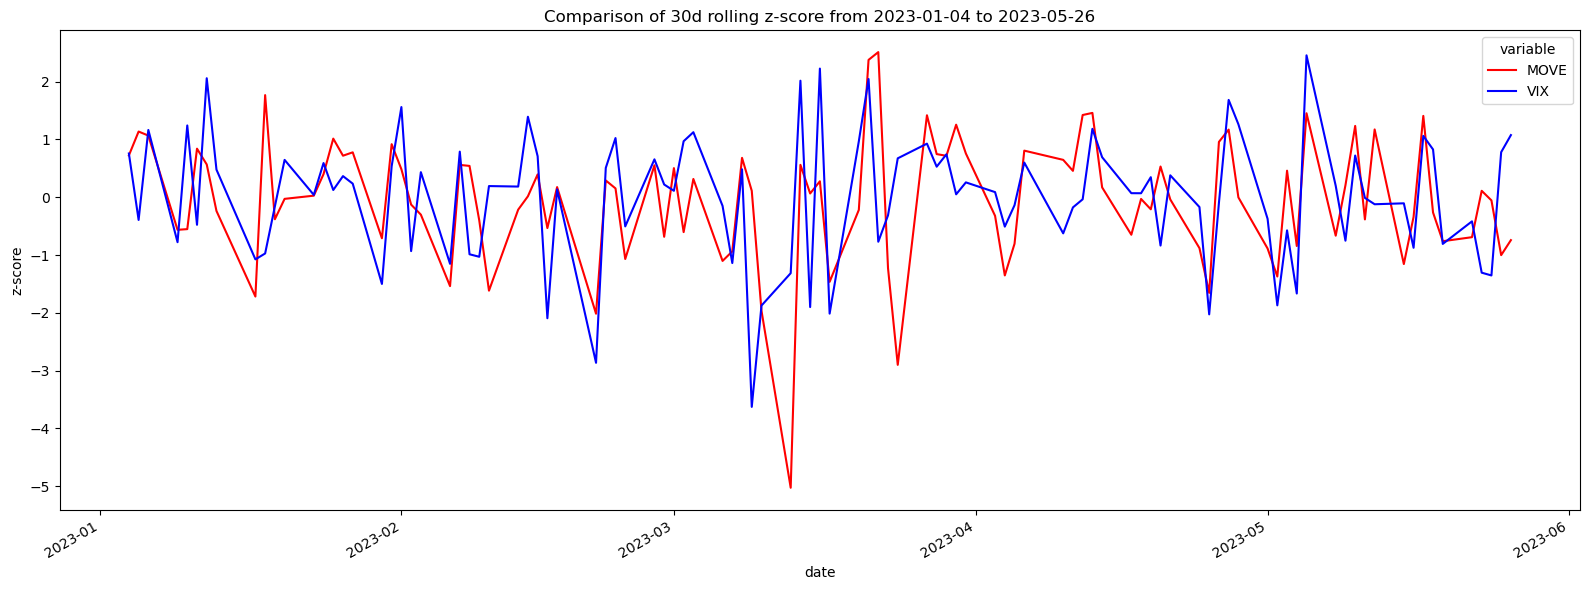

In [6]:
df_z_score_tail = df_z_score.tail(100)

fig, axes = plt.subplots(figsize = FIGSIZE)
(df_z_score_tail.plot(
    ax = axes,
    color = ["red", "blue"],
    ylabel = "z-score",
    title = "Comparison of 30d rolling z-score from {} to {}".format(
        df_z_score_tail.index.min().date(),
        df_z_score_tail.index.max().date())))

plt.tight_layout()
fig.savefig(os.path.join(out_path, "vix_move_z_score.jpeg"))

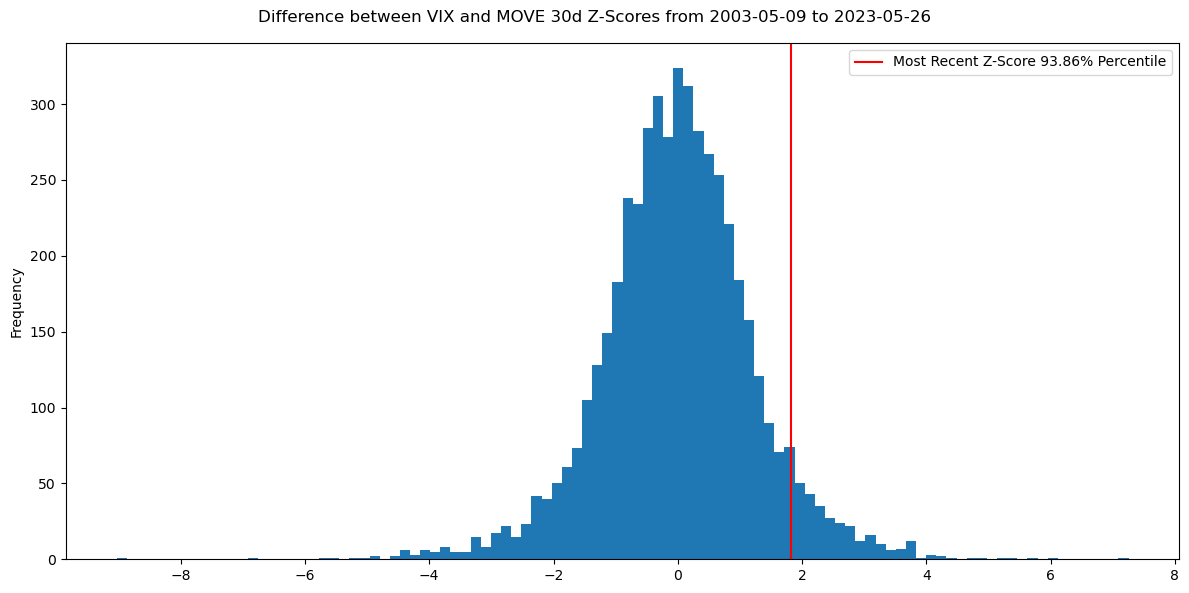

In [7]:
df_z_score_diff = (df_z_score.dropna().assign(
    diff = lambda x: x.VIX - x.MOVE)
    [["diff"]])

last_z_score = df_z_score_diff.reset_index().query("date == date.max()")["diff"].values[0]
percentile = stats.percentileofscore(df_z_score_diff["diff"].values, last_z_score)

fig, axes = plt.subplots(figsize = (12, 6))
axes.axvline(last_z_score, color = "red", label = "Most Recent Z-Score {}% Percentile".format(
    round(percentile,2)))

axes.legend()
df_z_score_diff.plot(
    kind = "hist", bins = 100,
    ax = axes, legend = False)

fig.suptitle("Difference between VIX and MOVE 30d Z-Scores from {} to {}".format(
    df_z_score_diff.index.min().date(),
    df_z_score_diff.index.max().date()))

fig.tight_layout()
fig.savefig(os.path.join(out_path, "vix_move_z_score_hist.jpeg"))

# Regression

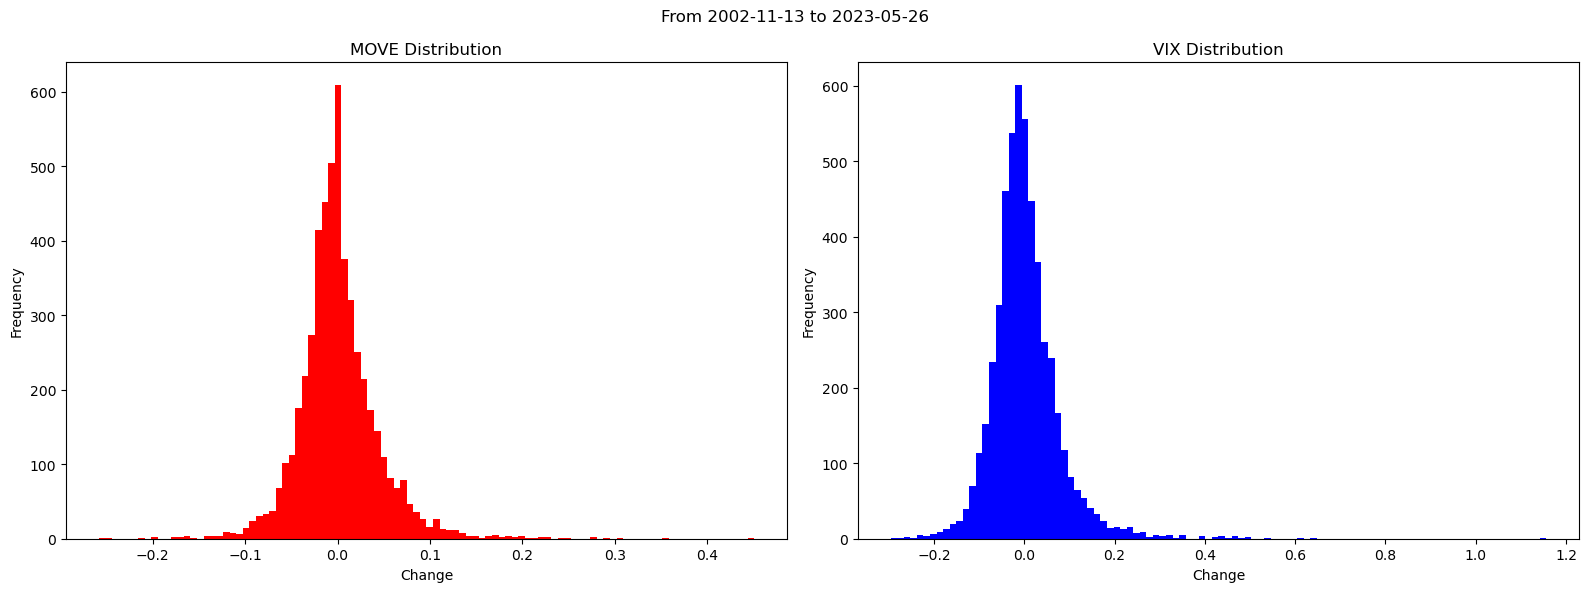

In [8]:
df_yf_wider = (df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    pct_change().
    dropna())

fig, axes = plt.subplots(ncols = 2, figsize = FIGSIZE)

axes[0].hist(
    df_yf_wider.MOVE,
    bins = 100,
    color = "red")
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Change")
axes[0].set_title("MOVE Distribution")

axes[1].hist(
    df_yf_wider.VIX,
    bins = 100,
    color = "blue")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Change")
axes[1].set_title("VIX Distribution")

fig.suptitle("From {} to {}".format(
    df_yf_wider.index.min().date(),
    df_yf_wider.index.max().date()))

plt.tight_layout()
plt.show()

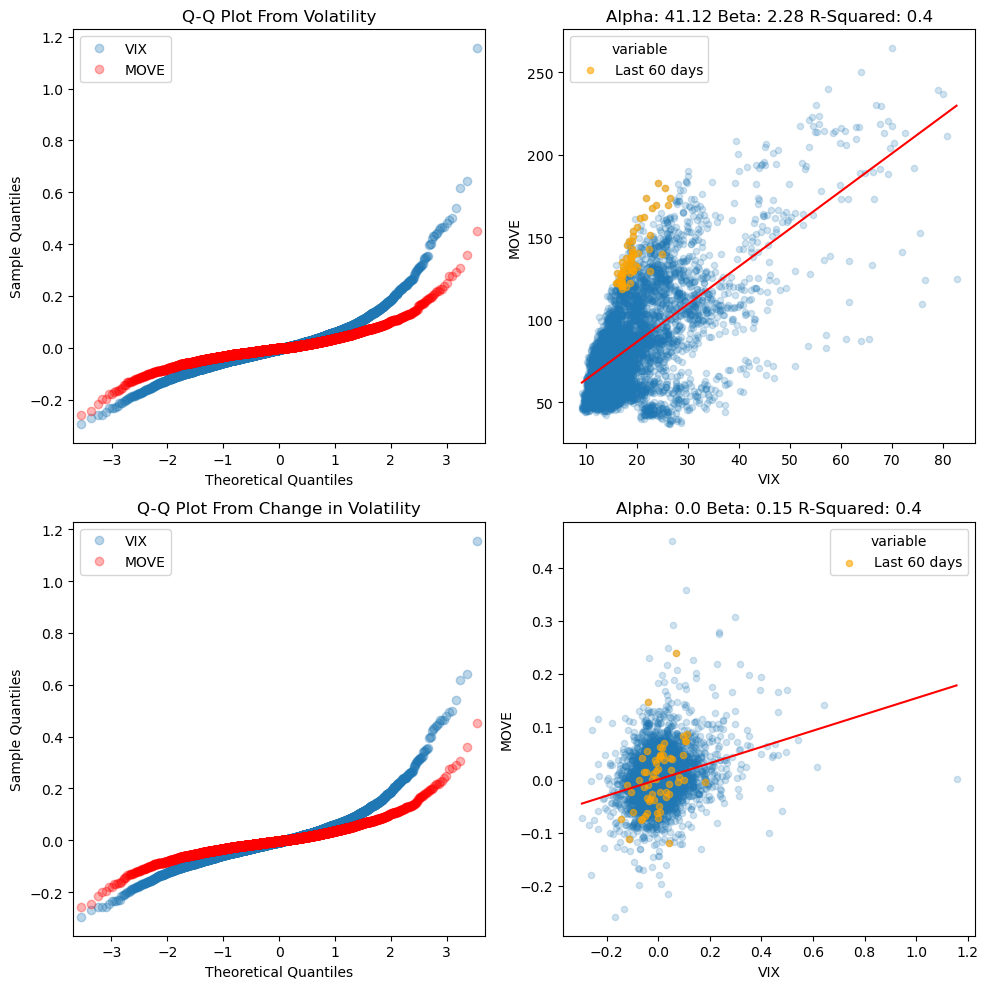

In [14]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 10))

_ = sm.qqplot(
    df_yf_wider.VIX,
    ax = axes[0,0],
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_yf_wider.MOVE,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[0,0],
    label = "MOVE")

df_yf_wider_raw = (df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    dropna())

axes[0,0].legend()
axes[0,0].set_title("Q-Q Plot From Volatility")

ols_model = (sm.OLS(
    endog = df_yf_wider_raw.MOVE,
    exog = sm.add_constant(df_yf_wider_raw.VIX)).
    fit())

alpha, beta = ols_model.params
x = np.linspace(
    start = df_yf_wider_raw.VIX.min(), 
    stop = df_yf_wider_raw.VIX.max(),
    num = 1_000)
y = (x * beta) + alpha

(df_yf_wider_raw.plot(
    kind = "scatter", x = "VIX", y = "MOVE",
    ax = axes[0,1],
    alpha = 0.2,
    title = "Alpha: {} Beta: {} R-Squared: {}".format(
        round(alpha, 2),
        round(beta, 2),
        round(ols_model.rsquared, 2))))

(df_yf_wider_raw.tail(
    60).
    plot(
        kind = "scatter", x = "VIX", y = "MOVE",
        ax = axes[0,1],
        alpha = 0.6,
        color = "orange",
        label = "Last 60 days"))

axes[0,1].plot(x, y, color = "r")

df_vol_change = df_yf_wider_raw.pct_change().dropna()
(df_vol_change.plot(
    ax = axes[1,1], kind = "scatter",
    x = "VIX", y = "MOVE",
    alpha = 0.2))

ols_model_rtn = (sm.OLS(
    endog = df_vol_change.MOVE,
    exog = sm.add_constant(df_vol_change.VIX)).
    fit())

alpha, beta = ols_model_rtn.params
x = np.linspace(
    start = df_vol_change.VIX.min(), 
    stop = df_vol_change.VIX.max(),
    num = 1_000)
y = (x * beta) + alpha

(df_vol_change.tail(
    60).
    plot(
        kind = "scatter", x = "VIX", y = "MOVE",
        ax = axes[1,1],
        alpha = 0.6,
        color = "orange",
        label = "Last 60 days",
        title = "Alpha: {} Beta: {} R-Squared: {}".format(
            round(alpha, 2), 
            round(beta, 2),
            round(ols_model.rsquared, 2))))

axes[1,1].plot(x, y, color = "r")

_ = sm.qqplot(
    df_vol_change.VIX,
    ax = axes[1,0],
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_vol_change.MOVE,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,0],
    label = "MOVE")

axes[1,0].legend()
axes[1,0].set_title("Q-Q Plot From Change in Volatility")

plt.tight_layout()

# Rolling Regressions

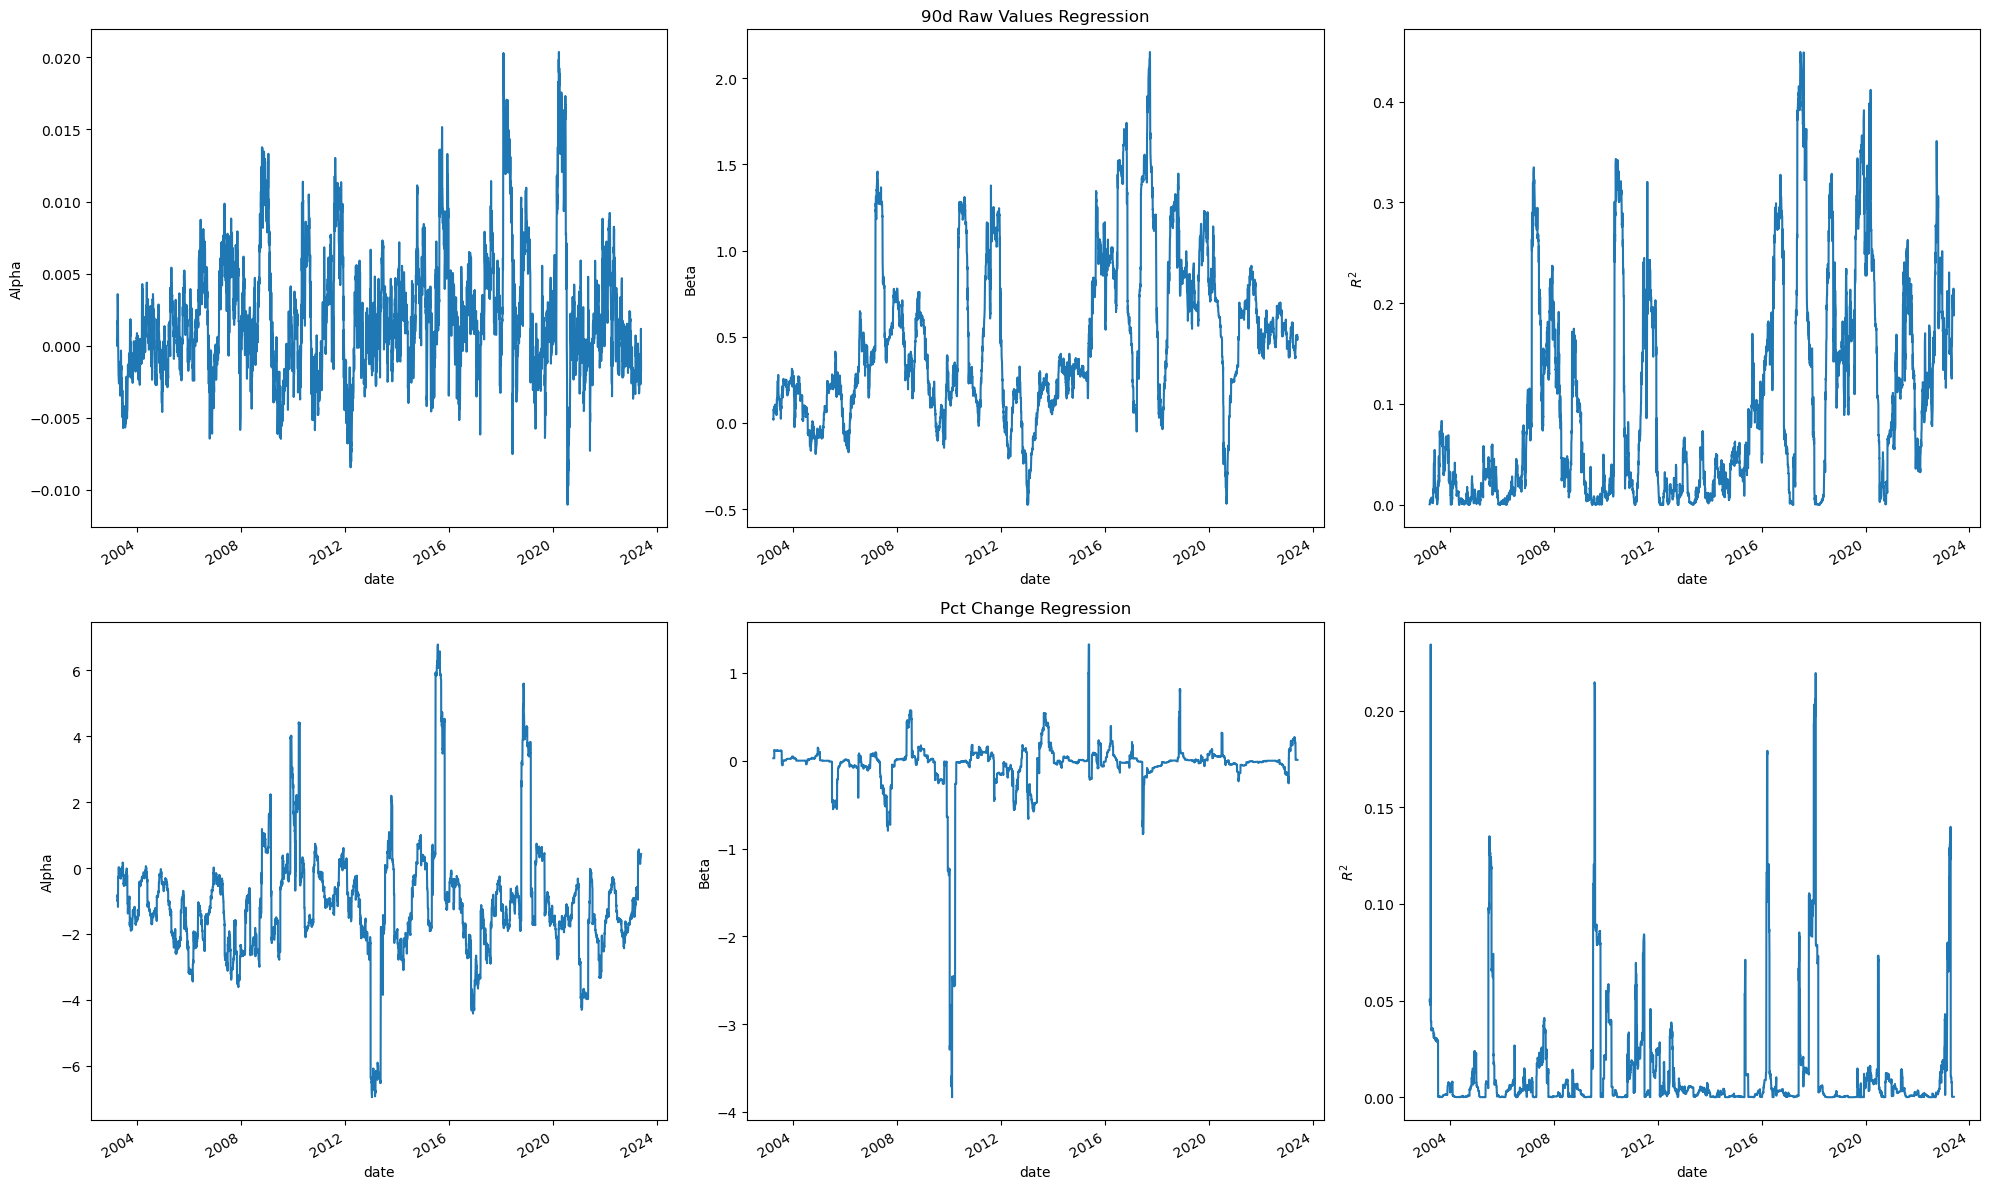

In [17]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (20,12))

raw_values_ols = (RollingOLS(
    endog = df_yf_wider.VIX,
    exog = sm.add_constant(df_yf_wider.MOVE),
    window = 90).
    fit())

raw_params = (raw_values_ols.params.dropna().rename(
    columns = {
        "const": "alpha",
        "MOVE": "beta"}))

(raw_params[
    ["alpha"]].
    plot(
        ax = axes[0,0],
        legend = False,
        ylabel = "Alpha"))

(raw_params[
    ["beta"]].
    plot(
        ax = axes[0,1],
        ylabel = "Beta",
        legend = False))

(raw_values_ols.rsquared.to_frame().dropna().rename(
    columns = {"0": "R-squared"}).
    plot(
        ax = axes[0,2],
        legend = False,
        ylabel = "$R^2$"))

df_yf_pct = (df_yf_wider.pct_change().dropna().reset_index().melt(
    id_vars = "date").
    query("value != Inf & value != -Inf").
    pivot(index = "date", columns = "variable", values = "value"))

pct_values_ols = (RollingOLS(
    endog = df_yf_pct.VIX,
    exog = sm.add_constant(df_yf_pct.MOVE),
    window = 90).
    fit())

pct_params = (pct_values_ols.params.dropna().rename(
    columns = {
        "const": "alpha",
        "MOVE": "beta"}))

(pct_params[
    ["alpha"]].
    plot(
        ax = axes[1,0],
        legend = False,
        ylabel = "Alpha"))

(pct_params[
    ["beta"]].
    plot(
        ax = axes[1,1],
        ylabel = "Beta",
        legend = False))

(pct_values_ols.rsquared.to_frame().dropna().rename(
    columns = {"0": "R-squared"}).
    plot(
        ax = axes[1,2],
        legend = False,
        ylabel = "$R^2$"))

axes[0,1].set_title("90d Raw Values Regression")
axes[1,1].set_title("Pct Change Regression")

plt.tight_layout()
plt.show()